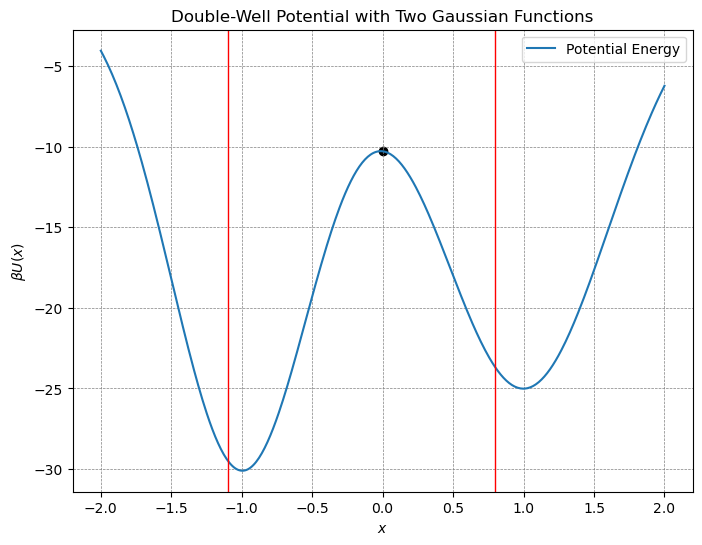

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator, CubicSpline

# Define the double-well potential using two Gaussian functions
def double_gaussian_potential(x, A1=30, mu1=-1, sigma1=0.5, A2=25, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
beta_U = double_gaussian_potential

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-2, 2, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0.8, color='red',linewidth=1)
plt.axvline(-1.1, color='red',linewidth=1)
plt.scatter(0, beta_U(0), color='black')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [2]:
a = 0.0   # location of Injecting point
b1 = -1.1  # location of lower absorbing boundary
b2 = 0.5   # location of upper absorbing boundary
h = 0.01
N = int((b2-b1)/h+1)
x_arr = np.linspace(b1, b2, N)
re_inject_idx = np.where(np.round(x_arr, decimals=10) == a)[0][0]

N1 = int((a-b1)/h+1)
N2 = int((b2-a)/h+1)
x1_arr = np.linspace(b1, a, N1)
x2_arr = np.linspace(a, b2, N2)

In [3]:
from transfer_matrix_recycle import TransferMatrix_AbInAb
from transfer_matrix_reptile import TransferMatrix_InReAb, TransferMatrix_AbReIn

aia_trans = TransferMatrix_AbInAb(h, x_arr, beta_U, recycle_idx=re_inject_idx, criteria=0)

ari1_trans = TransferMatrix_AbReIn(h, x1_arr, beta_U, 0)
ira2_trans = TransferMatrix_InReAb(h, x2_arr, beta_U, 0)

from mfpt_Pst_RW_regular_simu import simulate_AbInAb_regular

num_particles = 2000
init_position = a
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(b1, b2+h/2, h)
n_arr = np.round(n_arr, decimals=8)

In [4]:
%%time

count_n, ti_n = simulate_AbInAb_regular(init_point=init_position, num_particles=num_particles, beta_U=beta_U, n_arr=n_arr, b1=b1, b2=b2, hx=hx)

CPU times: user 29.6 s, sys: 66.1 ms, total: 29.7 s
Wall time: 29.7 s


In [5]:
# np.save('data/count_n_high', count_n)
# np.save('data/ti_n_high', ti_n)

2898.0 3232.0


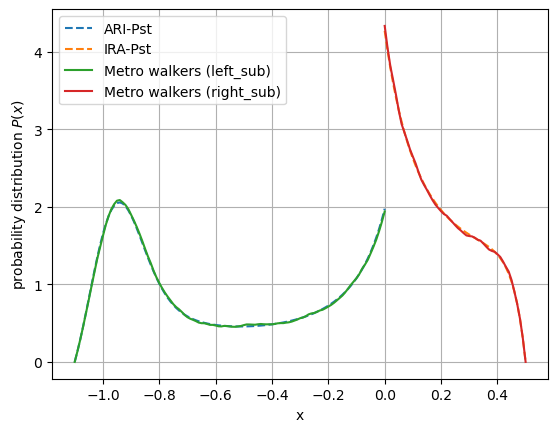

In [6]:
ari1_trans.steady_state[0] = 0
ira2_trans.steady_state[-1] = 0
ari1_trans.steady_state = ari1_trans.steady_state/(h*np.sum(ari1_trans.steady_state))
ira2_trans.steady_state = ira2_trans.steady_state/(h*np.sum(ira2_trans.steady_state))
plt.plot(x1_arr, ari1_trans.steady_state, '--', label="ARI-Pst")
plt.plot(x2_arr, ira2_trans.steady_state, '--', label="IRA-Pst")

n1_arr = n_arr[:N1]
n2_arr = n_arr[N1-1:]
count_n1 = count_n[:N1]
count_n2 = count_n[N1-1:]
print(count_n1[0], count_n2[-1])

count_n1[0] = 0 
count_n2[-1] = 0 
Pst_n1 = count_n1/(h*np.sum(count_n1))
Pst_n2 = count_n2/(h*np.sum(count_n2))
plt.plot(n1_arr, Pst_n1, label="Metro walkers (left_sub)")
plt.plot(n2_arr, Pst_n2, label="Metro walkers (right_sub)")

plt.xlabel('x')
plt.ylabel("probability distribution $P(x)$")
plt.legend()
plt.grid()
# plt.savefig("graphs/high_barrier_Pst.pdf", format='pdf')


/tmp/ipykernel_211114/3554627992.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(x1_arr, -np.log(Pst_n1), label='Metro walkers (left_sub)')
/tmp/ipykernel_211114/3554627992.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x2_arr, -np.log(Pst_n2), label='Metro walkers (right_sub)')
/tmp/ipykernel_211114/3554627992.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x1_arr, -np.log(ari1_trans.steady_state),'--', label="ARI-Pst")
/tmp/ipykernel_211114/3554627992.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x2_arr, -np.log(ira2_trans.steady_state), '--', label="IRA-Pst")


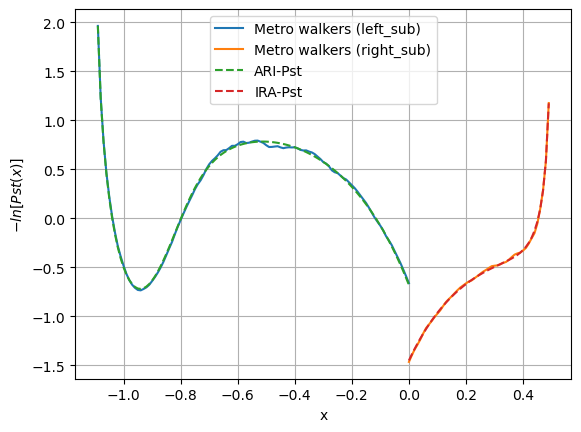

In [7]:
plt.plot(x1_arr, -np.log(Pst_n1), label='Metro walkers (left_sub)')
plt.plot(x2_arr, -np.log(Pst_n2), label='Metro walkers (right_sub)')
plt.plot(x1_arr, -np.log(ari1_trans.steady_state),'--', label="ARI-Pst")
plt.plot(x2_arr, -np.log(ira2_trans.steady_state), '--', label="IRA-Pst")
plt.xlabel('x')
plt.ylabel("$-ln[Pst(x)]$")
plt.grid()
plt.legend()

0.05062688268636517


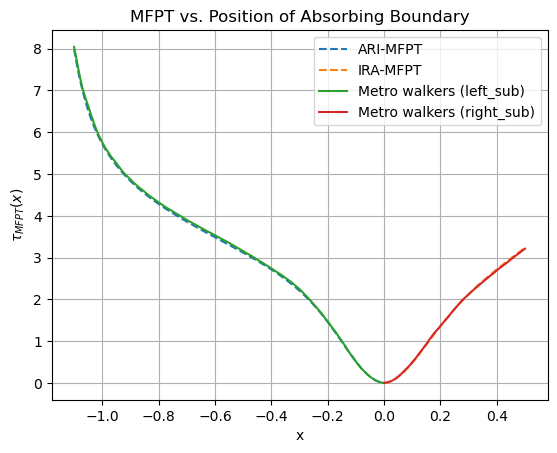

In [8]:
def mfpt_matrix(transMat_instance):
    ria_trans = transMat_instance
    ria_P = ria_trans.trans_mat.T
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    vec_pi = ria_trans.eig6_v[:,idx_fixed_vect].real/np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real)
    N = vec_pi.size
    epsilon = np.ones(N)
    mat_I = np.eye(N)
    mat_E = np.ones((N, N))
    mat_Z = np.linalg.inv(mat_I-ria_P+np.outer(epsilon, vec_pi))
    vec_Zdg = np.diag(mat_Z)
    mat_Zdg = np.diag(vec_Zdg)
    mat_Mdg = np.diag(1/vec_pi)
    mat_M = (mat_I - mat_Z + mat_E @ mat_Zdg) @ mat_Mdg
    mat_Mbar = mat_M - mat_Mdg
    return mat_Mbar

m1_bar = mfpt_matrix(ari1_trans)
m2_bar = mfpt_matrix(ira2_trans)
delt_t = h**2/(2*D0)
plt.plot(x1_arr, delt_t*m1_bar[-1], '--', label="ARI-MFPT")
plt.plot(x2_arr, delt_t*m2_bar[0], '--', label="IRA-MFPT")

mfpt_simu_arr = ht*np.mean(ti_n, axis=0)

# from scipy.interpolate import UnivariateSpline
# # Spline fitting with a specified smoothing factor
# spline_t = UnivariateSpline(n_arr, mfpt_simu, s=1)

# # Generate smooth curve points
# mfpt_simu_arr = spline_t(n_arr)

mfpt1_simu_arr = mfpt_simu_arr[ :N1]
mfpt2_simu_arr = mfpt_simu_arr[N1-1: ]

plt.plot(n1_arr, mfpt1_simu_arr, label="Metro walkers (left_sub)")
plt.plot(n2_arr, mfpt2_simu_arr, label="Metro walkers (right_sub)")

plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.title('MFPT vs. Position of Absorbing Boundary')
plt.legend()
plt.grid()
# plt.savefig("graphs/high_barrier_MFPT.pdf", format='pdf')

print(mfpt1_simu_arr[0]-delt_t*m1_bar[-1][0])
# -0.15316561731363443
# 0.03072438268636457
# 0.02686438268636504

### Define Functions for Reconstructing Free Energy with MFPT and steady state distribution

In [9]:
def reconstruct_energy_ra(x_arr, Pst_arr, mfpt_arr):
    # Pst_arr[-1] = 0
    interp_Pst_func = CubicSpline(x_arr, np.array(Pst_arr, dtype=float))
    N = x_arr.size
    # Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0
    Bx_arr = np.zeros(N-2)
    integral_Pst_arr = np.zeros(N-2)
    for i in range(N-2):
        integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
        Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])

    interp_invertBx_func = CubicSpline(x_arr[1:-1], 1.0/Bx_arr)
    integral_invertBx_arr = np.zeros(N-2)
    beta_Grec2_arr = np.zeros(N-2)
    for i in range(N-2):
        # Here x0 is x_arr[1]
        integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
        beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]
    return beta_Grec2_arr

def reconstruct_energy_ar(x_arr, Pst_arr, mfpt_arr):
    # Pst_arr[0] = 0
    interp_Pst_func = CubicSpline(x_arr, np.array(Pst_arr, dtype=float))
    N = x_arr.size
    # Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0
    Bx_arr = np.zeros(N-2)
    integral_Pst_arr = np.zeros(N-2)
    for i in range(N-2):
        integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[0], x_arr[1+i])
        Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]+(mfpt_arr[1+i]-mfpt_arr[0])/mfpt_arr[0])

    interp_invertBx_func = CubicSpline(x_arr[1:-1], 1.0/Bx_arr)
    integral_invertBx_arr = np.zeros(N-2)
    beta_Grec2_arr = np.zeros(N-2)
    for i in range(N-2):
        # Here x0 is x_arr[1]
        integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1+i], x_arr[-2])
        beta_Grec2_arr[i] = beta_U(x_arr[-2])+np.log(Bx_arr[i]/Bx_arr[-1])-integral_invertBx_arr[i]
    return beta_Grec2_arr

### Reconstruction Using data [mfpt (mfpt1_simu_arr), Pst (Pst_n)] extracted from simulation

/tmp/ipykernel_211114/2877723197.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[0], x_arr[1+i])
/tmp/ipykernel_211114/2877723197.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the 

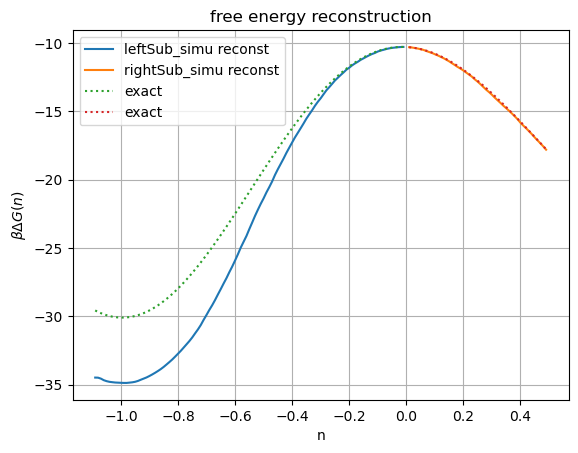

In [10]:
# np.append(delt_t*m1_bar[-1][0], mfpt1_simu_arr[1:])
beta_Grec2_arr1 = reconstruct_energy_ar(n1_arr, Pst_arr=Pst_n1, mfpt_arr=mfpt1_simu_arr)
beta_Grec2_arr2 = reconstruct_energy_ra(n2_arr, Pst_arr=Pst_n2, mfpt_arr=mfpt2_simu_arr)
# print(Pst_n1[0], Pst_n2[-1], hx*np.sum(Pst_n1), hx*np.sum(Pst_n2))
plt.plot(n1_arr[1:-1], beta_Grec2_arr1, label="leftSub_simu reconst")
plt.plot(n2_arr[1:-1], beta_Grec2_arr2, label="rightSub_simu reconst")
plt.plot(x1_arr[1:-1], beta_U(x1_arr[1:-1]), ':', label="exact")
plt.plot(x2_arr[1:-1], beta_U(x2_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()
# plt.savefig("graphs/high_barrier_reconstruction.pdf", format='pdf')

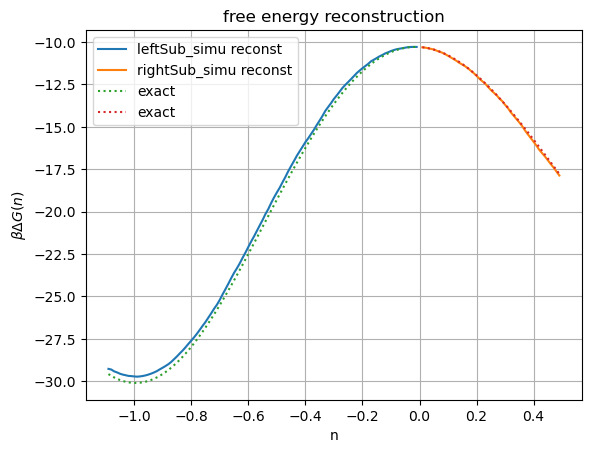

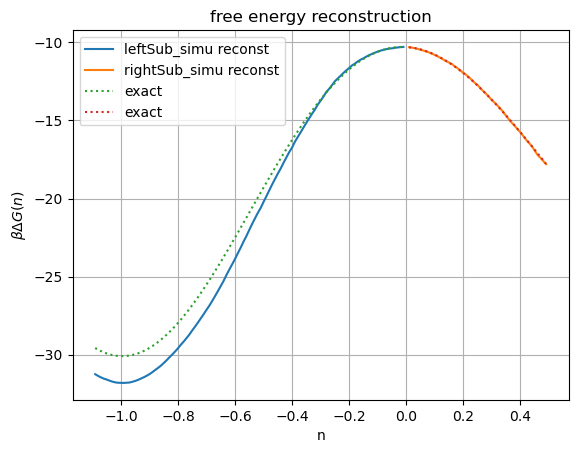

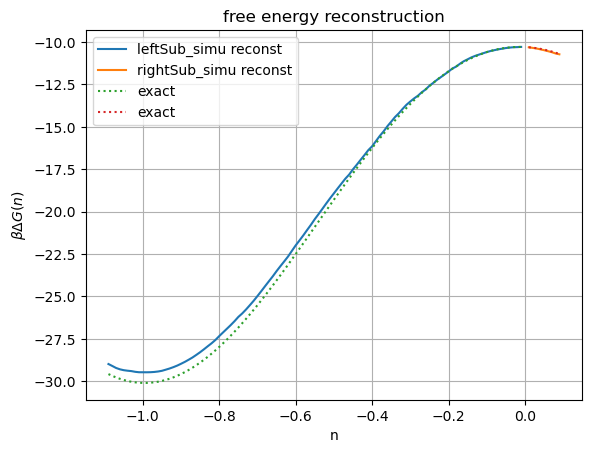

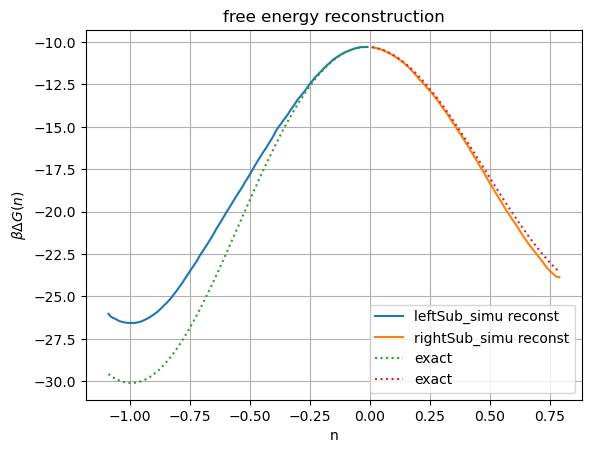

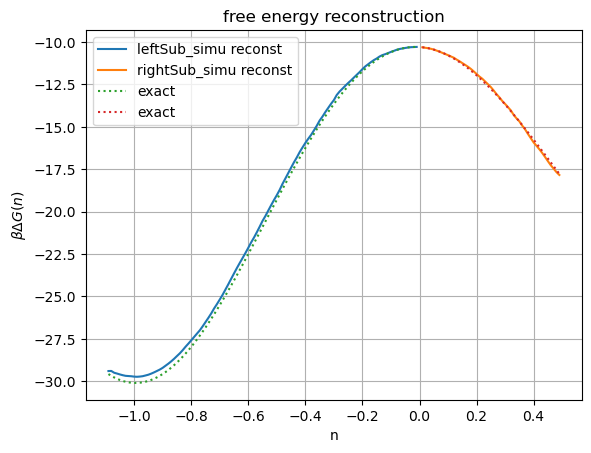

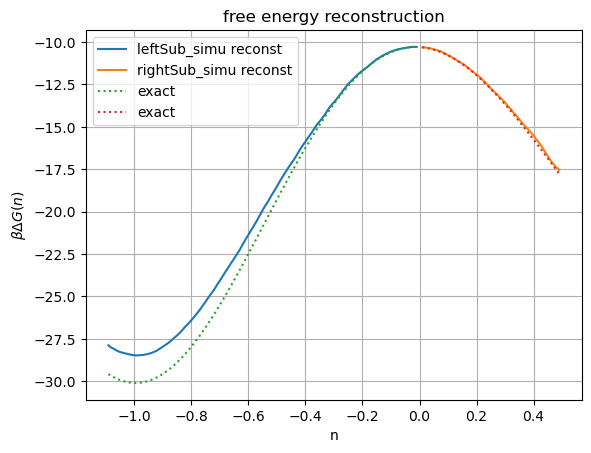

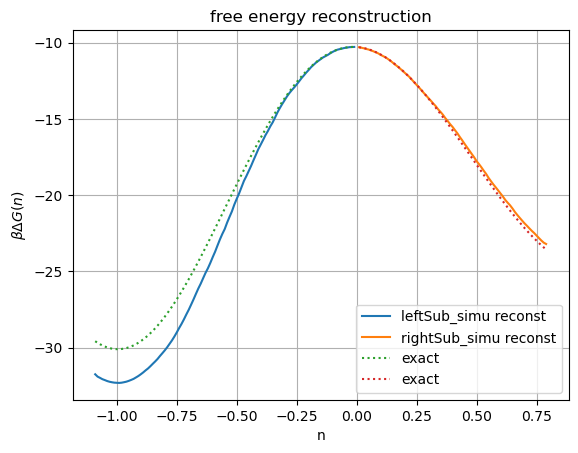

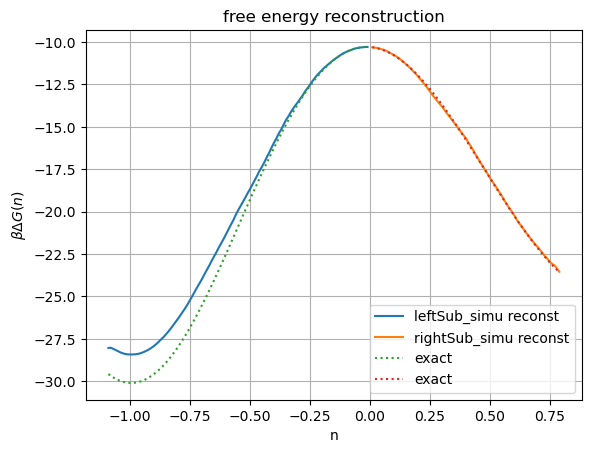

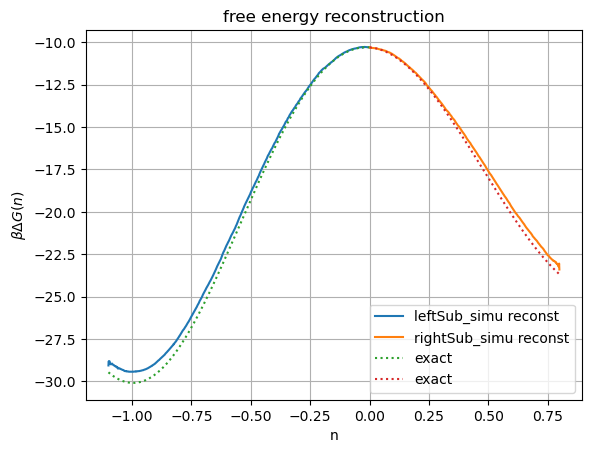

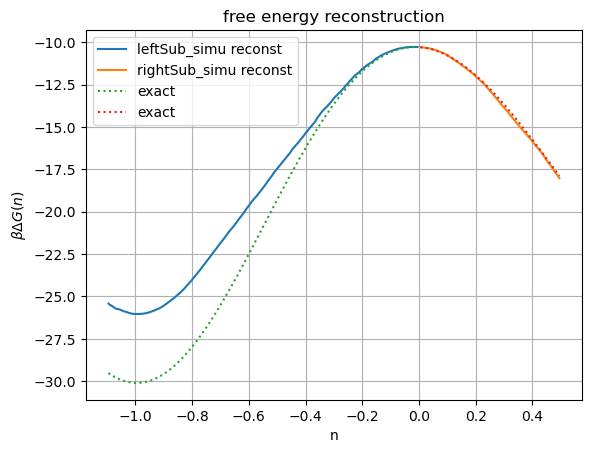

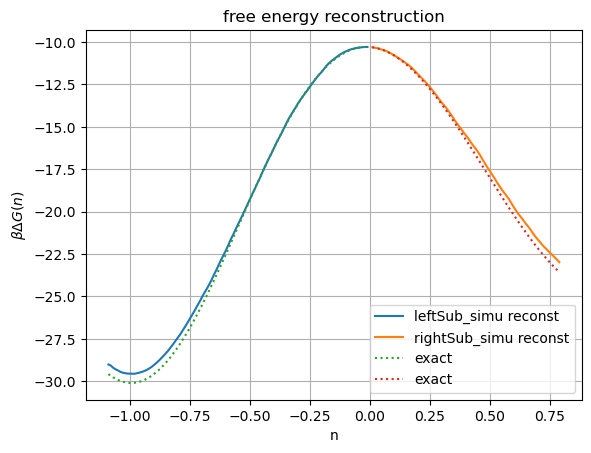

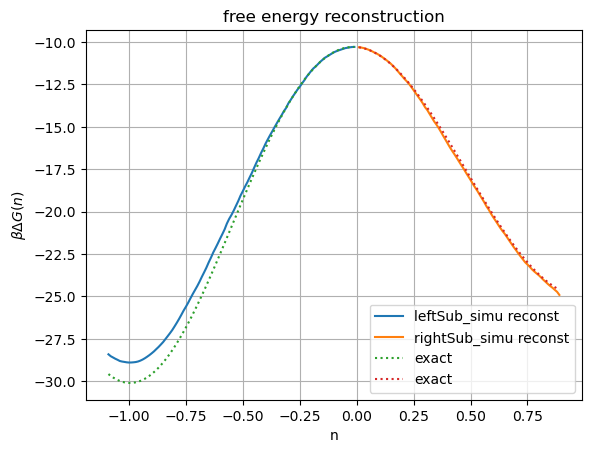

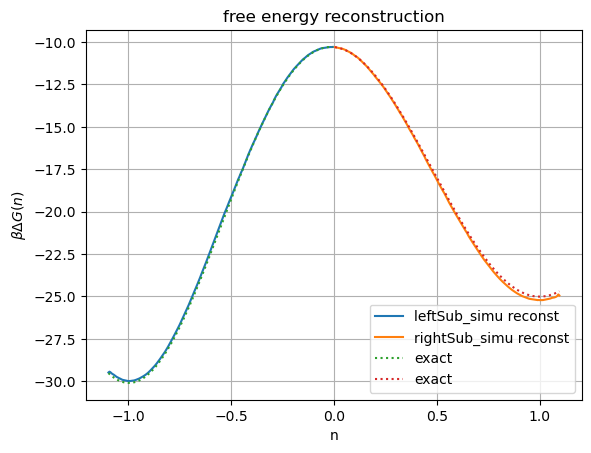

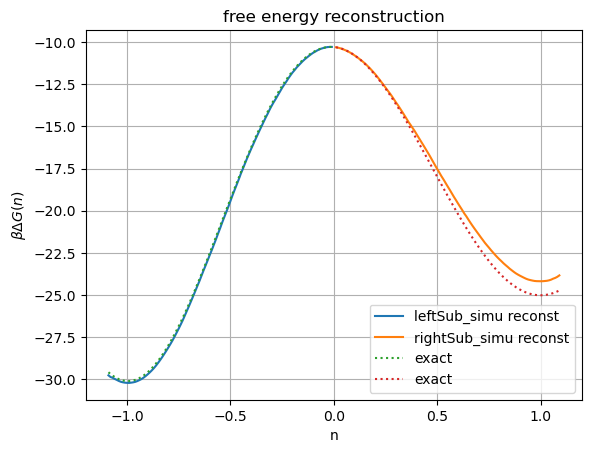

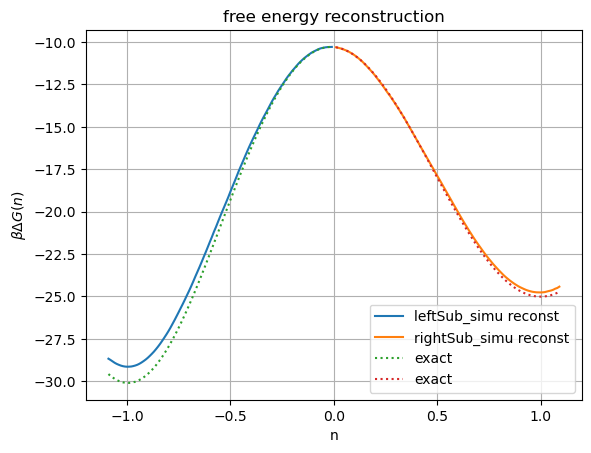

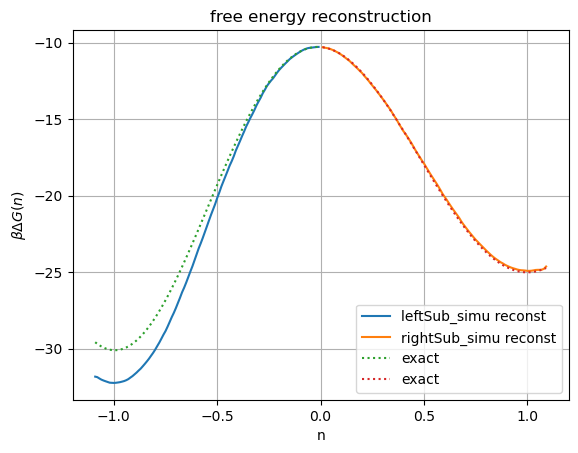

### Reconstruction Using data [mfpt matrix (mat_Mbar[i]), Pst (ria_trans.steady_state)] calculated by Transfer Matrix

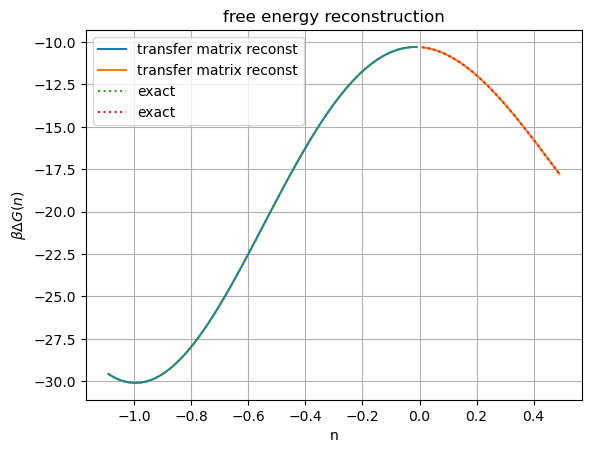

In [11]:
beta_Grec2_arr1 = reconstruct_energy_ar(x1_arr, Pst_arr=ari1_trans.steady_state, mfpt_arr=m1_bar[-1])
beta_Grec2_arr2 = reconstruct_energy_ra(x2_arr, Pst_arr=ira2_trans.steady_state, mfpt_arr=m2_bar[0])

plt.plot(x1_arr[1:-1], beta_Grec2_arr1, label="transfer matrix reconst")
plt.plot(x2_arr[1:-1], beta_Grec2_arr2, label="transfer matrix reconst")

plt.plot(x1_arr[1:-1], beta_U(x1_arr[1:-1]), ':', label="exact")
plt.plot(x2_arr[1:-1], beta_U(x2_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()